In [35]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

data = pd.read_csv('preprocessed_data.csv')

# Danh sách cột loại bỏ (Dựa trên Feature Importance và logic khí tượng)
cols_to_drop = [
    'weather_group'
]

X = data.drop(columns=cols_to_drop)
y = data['weather_group'].astype('category').cat.codes

# --- BƯỚC 2: CHIA DỮ LIỆU (TIME SERIES SAFE) ---
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)
# Chia nhỏ train để lấy validation phục vụ Early Stopping
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.15, random_state=42, shuffle=False)

# --- BƯỚC 3: SCALING ĐỒNG NHẤT ---
# Lấy tất cả các cột trừ sin/cos (thực tế scale cả sin/cos cũng không hại gì)
all_features = X.columns.tolist()
scaler = RobustScaler()

X_train_scaled = X_train.copy()
X_val_scaled = X_val.copy()
X_test_scaled = X_test.copy()

X_train_scaled[all_features] = scaler.fit_transform(X_train[all_features])
X_val_scaled[all_features] = scaler.transform(X_val[all_features])
X_test_scaled[all_features] = scaler.transform(X_test[all_features])

Fitting 3 folds for each of 5 candidates, totalling 15 fits


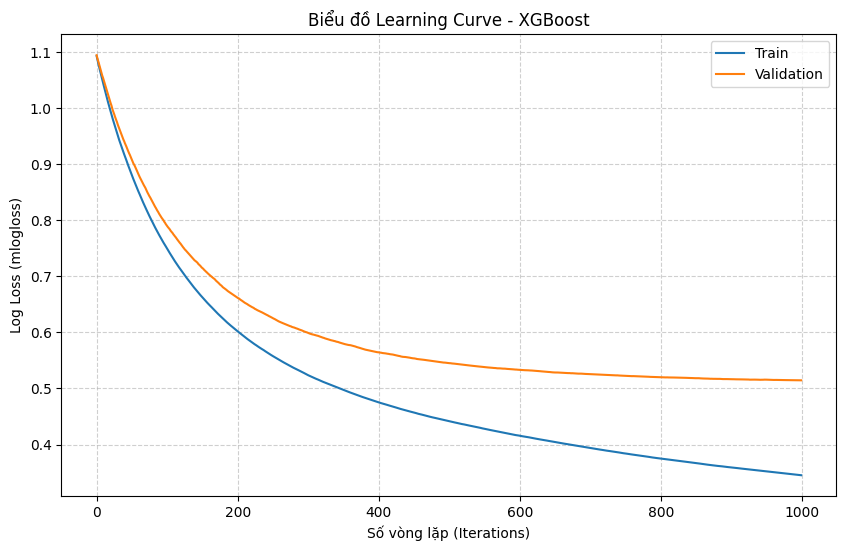


ACCURACY TẬP TEST: 0.6534

BÁO CÁO PHÂN LOẠI:
               precision    recall  f1-score   support

      Cloudy       0.85      0.58      0.69      1673
     Drizzle       0.57      0.72      0.63      1366
        Rain       0.53      0.72      0.61       472

    accuracy                           0.65      3511
   macro avg       0.65      0.67      0.64      3511
weighted avg       0.70      0.65      0.66      3511



In [42]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
from sklearn.utils.class_weight import compute_class_weight

# ==========================================
# 1. LOAD DỮ LIỆU & FEATURE ENGINEERING
# ==========================================
df = pd.read_csv('preprocessed_data.csv')

robust_features = [
    'temperature_2m', 'relative_humidity_2m', 'dew_point_2m',
    'surface_pressure', 'wind_speed_10m', 'humidity_change', 
    'pressure_trend_6h', 'press_std_12h', 'temp_diff_3h'
]
pass_through_features = [
    'hour_sin', 'hour_cos', 'month_sin', 'month_cos', 'cloud_cover'
]

def prepare_data(df):
    features_to_keep = robust_features + pass_through_features + ['weather_group']
    df = df[features_to_keep].copy()
    df = df.dropna().reset_index(drop=True)
    X = df.drop(columns=['weather_group'])
    y = df['weather_group'].astype('category').cat.codes
    return X, y, df['weather_group'].astype('category').cat.categories

X, y, class_names = prepare_data(df)

# ==========================================
# 2. CHIA DỮ LIỆU & SCALING
# ==========================================
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=False
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size=0.15, random_state=42, shuffle=False
)

robust_scaler = RobustScaler()
X_train_scaled = X_train.copy()
X_val_scaled = X_val.copy()
X_test_scaled = X_test.copy()

X_train_scaled[robust_features] = robust_scaler.fit_transform(X_train[robust_features])
X_val_scaled[robust_features] = robust_scaler.transform(X_val[robust_features])
X_test_scaled[robust_features] = robust_scaler.transform(X_test[robust_features])

# ==========================================
# 3. XỬ LÝ MẤT CÂN BẰNG LỚP
# ==========================================
classes = np.unique(y_train)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weights_dict = dict(zip(classes, weights))
sample_weights = pd.Series(y_train).map(class_weights_dict)

# ==========================================
# 4. TỐI ƯU HÓA SIÊU THAM SỐ
# ==========================================
param_dist = {
    'n_estimators': [1000, 2000],
    'max_depth': [6, 8, 10],
    'learning_rate': [0.01, 0.05],
    'gamma': [0.5, 1],
    'reg_lambda': [10, 20],
    'subsample': [0.7, 0.8],
    'colsample_bytree': [0.7, 0.8]
}

xgb_base = xgb.XGBClassifier(random_state=42, tree_method='hist', eval_metric='mlogloss')
cv_strategy = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

search = RandomizedSearchCV(
    estimator=xgb_base, param_distributions=param_dist, 
    n_iter=5, scoring='f1_macro', cv=cv_strategy, verbose=1, n_jobs=-1
)

search.fit(X_train_scaled, y_train, sample_weight=sample_weights)
best_params = search.best_params_

# ==========================================
# 5. HUẤN LUYỆN LẠI ĐỂ LẤY RESULTS CHO LEARNING CURVE
# ==========================================
# Khởi tạo lại mô hình với tham số tốt nhất để theo dõi quá trình train/val
final_model = xgb.XGBClassifier(**best_params, random_state=42, tree_method='hist', early_stopping_rounds=50,eval_metric='mlogloss')

final_model.fit(
    X_train_scaled, y_train,
    sample_weight=sample_weights,
    eval_set=[(X_train_scaled, y_train), (X_val_scaled, y_val)],
    
    verbose=False
)

# ==========================================
# 6. VẼ LEARNING CURVE
# ==========================================
results = final_model.evals_result()
epochs = len(results['validation_0']['mlogloss'])
x_axis = range(0, epochs)

plt.figure(figsize=(10, 6))
plt.plot(x_axis, results['validation_0']['mlogloss'], label='Train')
plt.plot(x_axis, results['validation_1']['mlogloss'], label='Validation')
plt.legend()
plt.ylabel('Log Loss (mlogloss)')
plt.xlabel('Số vòng lặp (Iterations)')
plt.title('Biểu đồ Learning Curve - XGBoost')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# ==========================================
# 7. ĐÁNH GIÁ CHI TIẾT
# ==========================================
y_pred = final_model.predict(X_test_scaled)
print("\n" + "="*30)
print(f"ACCURACY TẬP TEST: {accuracy_score(y_test, y_pred):.4f}")
print("="*30)
print("\nBÁO CÁO PHÂN LOẠI:\n", classification_report(y_test, y_pred, target_names=class_names))

Fitting 3 folds for each of 10 candidates, totalling 30 fits

Tham số tối ưu nhất: {'subsample': 0.8, 'reg_lambda': 20, 'reg_alpha': 10, 'n_estimators': 2500, 'min_child_weight': 10, 'max_depth': 5, 'learning_rate': 0.02, 'gamma': 1, 'colsample_bytree': 0.6}


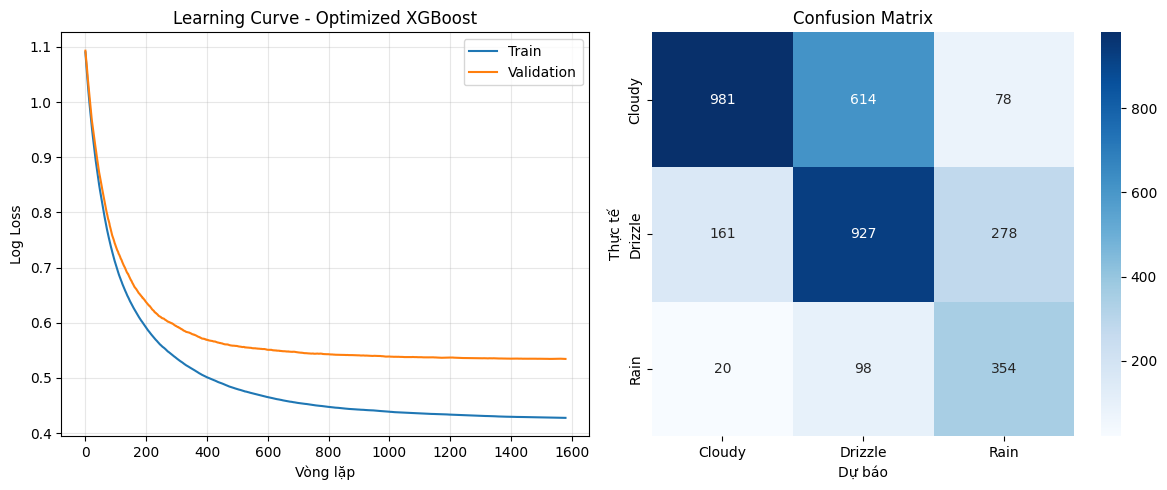


ACCURACY TRÊN TẬP TEST: 0.6443

BÁO CÁO PHÂN LOẠI:
               precision    recall  f1-score   support

      Cloudy       0.84      0.59      0.69      1673
     Drizzle       0.57      0.68      0.62      1366
        Rain       0.50      0.75      0.60       472

    accuracy                           0.64      3511
   macro avg       0.64      0.67      0.64      3511
weighted avg       0.69      0.64      0.65      3511



In [46]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
from sklearn.preprocessing import QuantileTransformer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
from sklearn.utils.class_weight import compute_class_weight

# ==========================================
# 1. LOAD DỮ LIỆU & FEATURE ENGINEERING
# ==========================================
df = pd.read_csv('preprocessed_data.csv')

# Danh sách feature đã lọc từ các ma trận tương quan trước đó
robust_features = [
    'temperature_2m', 'relative_humidity_2m', 'dew_point_2m',
    'surface_pressure', 'wind_speed_10m', 'humidity_change', 
    'pressure_trend_6h', 'press_std_12h', 'temp_diff_3h'
]
pass_through_features = [
    'hour_sin', 'hour_cos', 'month_sin', 'month_cos', 'cloud_cover'
]

def prepare_data(df):
    # Loại bỏ hum_max_6h do tương quan cao (0.70) với relative_humidity_2m để giảm đa cộng tuyến
    features_to_keep = robust_features + pass_through_features + ['weather_group']
    df = df[features_to_keep].copy()
    df = df.dropna().reset_index(drop=True)
    
    X = df.drop(columns=['weather_group'])
    y = df['weather_group'].astype('category').cat.codes
    return X, y, df['weather_group'].astype('category').cat.categories

X, y, class_names = prepare_data(df)

# ==========================================
# 2. CHIA DỮ LIỆU & SCALING TỐI ƯU
# ==========================================
# Chia theo thời gian (shuffle=False) để đảm bảo tính thực tế của dự báo thời tiết
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=False
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size=0.15, random_state=42, shuffle=False
)

# Sử dụng QuantileTransformer giúp đưa các đặc trưng khí tượng về phân phối chuẩn
# Điều này cực kỳ hiệu quả cho mô hình khi gặp dữ liệu có nhiều biến động đột ngột
scaler = QuantileTransformer(output_distribution='normal', random_state=42)

X_train_scaled = X_train.copy()
X_val_scaled = X_val.copy()
X_test_scaled = X_test.copy()

X_train_scaled[robust_features] = scaler.fit_transform(X_train[robust_features])
X_val_scaled[robust_features] = scaler.transform(X_val[robust_features])
X_test_scaled[robust_features] = scaler.transform(X_test[robust_features])

# ==========================================
# 3. XỬ LÝ MẤT CÂN BẰNG LỚP (Class Weights)
# ==========================================
classes = np.unique(y_train)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
sample_weights = pd.Series(y_train).map(dict(zip(classes, weights)))

# ==========================================
# 4. RANDOMIZED SEARCH - TĂNG CƯỜNG REGULARIZATION
# ==========================================
param_dist = {
    'n_estimators': [1500, 2500],
    'max_depth': [5, 7, 9],               # Giảm độ sâu nhẹ để bám sát đường Validation
    'learning_rate': [0.01, 0.02],
    'min_child_weight': [1, 5, 10],       # Ngăn mô hình học các lá quá nhỏ (nhiễu)
    'gamma': [1, 2, 5],                   # Ép mô hình tối giản hóa cấu trúc cây
    'subsample': [0.6, 0.8],
    'colsample_bytree': [0.6, 0.8],
    'reg_lambda': [20, 50],               # Tăng mạnh L2 để giảm biên độ trọng số
    'reg_alpha': [5, 10]                  # Tăng L1 để loại bỏ các đặc trưng ít quan trọng
}

xgb_base = xgb.XGBClassifier(random_state=42, tree_method='hist')
cv_strategy = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

search = RandomizedSearchCV(
    estimator=xgb_base, param_distributions=param_dist, 
    n_iter=10, scoring='f1_macro', cv=cv_strategy, verbose=1, n_jobs=-1
)

search.fit(X_train_scaled, y_train, sample_weight=sample_weights)
best_params = search.best_params_
print(f"\nTham số tối ưu nhất: {best_params}")

# ==========================================
# 5. HUẤN LUYỆN LẠI VỚI EARLY STOPPING
# ==========================================
final_model = xgb.XGBClassifier(
    **best_params, 
    random_state=42, 
    tree_method='hist', 
    early_stopping_rounds=50, 
    eval_metric='mlogloss'
)

final_model.fit(
    X_train_scaled, y_train,
    sample_weight=sample_weights,
    eval_set=[(X_train_scaled, y_train), (X_val_scaled, y_val)],
    verbose=False
)

# ==========================================
# 6. VẼ LEARNING CURVE & ĐÁNH GIÁ
# ==========================================
results = final_model.evals_result()
epochs = len(results['validation_0']['mlogloss'])

plt.figure(figsize=(12, 5))
# Biểu đồ Learning Curve
plt.subplot(1, 2, 1)
plt.plot(range(epochs), results['validation_0']['mlogloss'], label='Train')
plt.plot(range(epochs), results['validation_1']['mlogloss'], label='Validation')
plt.title('Learning Curve - Optimized XGBoost')
plt.xlabel('Vòng lặp')
plt.ylabel('Log Loss')
plt.legend()
plt.grid(True, alpha=0.3)

# Biểu đồ Confusion Matrix
y_pred = final_model.predict(X_test_scaled)
cm = confusion_matrix(y_test, y_pred)
plt.subplot(1, 2, 2)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Dự báo')
plt.ylabel('Thực tế')
plt.tight_layout()
plt.show()

# In báo cáo chi tiết
print("\n" + "="*40)
print(f"ACCURACY TRÊN TẬP TEST: {accuracy_score(y_test, y_pred):.4f}")
print("="*40)
print("\nBÁO CÁO PHÂN LOẠI:\n", classification_report(y_test, y_pred, target_names=class_names))

In [39]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
# Sửa lỗi typo: confusion_material -> confusion_matrix
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
from sklearn.utils.class_weight import compute_class_weight

# ==========================================
# 1. LOAD DỮ LIỆU & FEATURE ENGINEERING
# ==========================================
df = pd.read_csv('preprocessed_data.csv')

def engineer_features(df):
    # D. Loại bỏ cột dư thừa/nhiễu
    cols_to_drop = [
        'weather_group',
        'hum_max_6h'
    ]
    
    # Loại bỏ các dòng NaN tạo ra do rolling/diff
    df = df.dropna().reset_index(drop=True)
    
    X = df.drop(columns=cols_to_drop)
    y = df['weather_group'].astype('category').cat.codes
    return X, y
cols_to_drop = [
        'weather_group' ]
# X, y = engineer_features(data)
X = df.drop(columns=cols_to_drop)
y = df['weather_group'].astype('category').cat.codes
# ==========================================
# 2. CHIA DỮ LIỆU & SCALING
# ==========================================
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=False
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size=0.15, random_state=42, shuffle=False
)

from sklearn.preprocessing import RobustScaler

# Chỉ scale các cột có đơn vị đo lớn hoặc có outliers
robust_features = [
    'temperature_2m', 'relative_humidity_2m', 'dew_point_2m',
    'surface_pressure', 'wind_speed_10m', 'humidity_change', 
    'pressure_trend_6h', 'press_std_12h', 'temp_diff_3h'
]

# Các cột giữ nguyên (đã ở dạng sin/cos hoặc tỉ lệ 0-1)
pass_through_features = [
    'hour_sin', 'hour_cos', 'month_sin', 'month_cos', 'cloud_cover'
]

robust_scaler = RobustScaler()

X_train_scaled = X_train.copy()
X_val_scaled = X_val.copy()
X_test_scaled = X_test.copy()

# Chỉ fit_transform trên nhóm khí tượng
X_train_scaled[robust_features] = robust_scaler.fit_transform(X_train[robust_features])
X_val_scaled[robust_features] = robust_scaler.transform(X_val[robust_features])
X_test_scaled[robust_features] = robust_scaler.transform(X_test[robust_features])

# ==========================================
# 3. XỬ LÝ MẤT CÂN BẰNG LỚP
# ==========================================
classes = np.unique(y_train)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weights_dict = dict(zip(classes, weights))
sample_weights = pd.Series(y_train).map(class_weights_dict)

# ==========================================
# 4. HUẤN LUYỆN XGBOOST TỐI ƯU
# ==========================================
model = xgb.XGBClassifier(
n_estimators=5000,
    learning_rate=0.001,   # Học chậm hơn
    max_depth=10,          # Giảm độ sâu để tránh học nhiễu
    reg_lambda=15,        # Tăng L2 Regularization để ép trọng số nhỏ đi
    reg_alpha=2,          # Thêm L1 Regularization
    gamma=1.0,            # Ép mô hình chỉ phân nhánh khi thực sự có lợi lớn
    subsample=0.7,
    colsample_bytree=0.7,
    random_state=42,
    early_stopping_rounds=50,
    eval_metric='mlogloss'
)

model.fit(
    X_train_scaled, y_train,
    sample_weight=sample_weights,
    eval_set=[(X_train_scaled, y_train), (X_val_scaled, y_val)],
    verbose=100
)

# ==========================================
# 5. ĐÁNH GIÁ CHI TIẾT
# ==========================================
y_pred = model.predict(X_test_scaled)
print("\n" + "="*30)
print(f"ACCURACY TRÊN TẬP TEST: {accuracy_score(y_test, y_pred):.4f}")
print("="*30)
print("\nBÁO CÁO PHÂN LOẠI:\n", classification_report(y_test, y_pred))

[0]	validation_0-mlogloss:1.09800	validation_1-mlogloss:1.09812
[100]	validation_0-mlogloss:1.04336	validation_1-mlogloss:1.04996
[200]	validation_0-mlogloss:0.99404	validation_1-mlogloss:1.00679
[300]	validation_0-mlogloss:0.94960	validation_1-mlogloss:0.96813
[400]	validation_0-mlogloss:0.90912	validation_1-mlogloss:0.93281
[500]	validation_0-mlogloss:0.87274	validation_1-mlogloss:0.90110
[600]	validation_0-mlogloss:0.83940	validation_1-mlogloss:0.87278
[700]	validation_0-mlogloss:0.80919	validation_1-mlogloss:0.84644
[800]	validation_0-mlogloss:0.78155	validation_1-mlogloss:0.82233
[900]	validation_0-mlogloss:0.75601	validation_1-mlogloss:0.79979
[1000]	validation_0-mlogloss:0.73266	validation_1-mlogloss:0.77970
[1100]	validation_0-mlogloss:0.71098	validation_1-mlogloss:0.76108
[1200]	validation_0-mlogloss:0.69090	validation_1-mlogloss:0.74411
[1300]	validation_0-mlogloss:0.67230	validation_1-mlogloss:0.72855
[1400]	validation_0-mlogloss:0.65523	validation_1-mlogloss:0.71412
[1500]	

In [ ]:
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold

# ==========================================
# 4. GRID SEARCH / RANDOMIZED SEARCH
# ==========================================

# 4.1 Định nghĩa không gian tham số
param_dist = {
    'n_estimators': [500, 1000, 2000],
    'max_depth': [6, 8, 10],
    'learning_rate': [0.01, 0.05, 0.1],
    'gamma': [0.5, 1, 1.5],
    'subsample': [0.6, 0.8],
    'colsample_bytree': [0.6, 0.8],
    'reg_lambda': [10, 15, 20],
    'reg_alpha': [1, 2, 5]
}

# 4.2 Khởi tạo mô hình cơ bản
xgb_base = xgb.XGBClassifier(
    random_state=42,
    eval_metric='mlogloss',
    tree_method='hist' # Sử dụng 'hist' để tăng tốc độ huấn luyện
)

# 4.3 Thiết lập Cross-Validation (Dùng Stratified để giữ tỉ lệ lớp)
cv_strategy = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# 4.4 Khởi tạo Search
# Lưu ý: Chúng ta dùng sample_weight trong fit_params
random_search = RandomizedSearchCV(
    estimator=xgb_base,
    param_distributions=param_dist,
    n_iter=10,             # Thử nghiệm 10 bộ tham số ngẫu nhiên
    scoring='f1_macro',    # Ưu tiên F1-macro cho dữ liệu thiếu cân bằng
    cv=cv_strategy,
    verbose=2,
    random_state=42,
    n_jobs=-1              # Sử dụng toàn bộ nhân CPU
)

# 4.5 Chạy Search
print("Đang tìm kiếm bộ tham số tối ưu...")
random_search.fit(
    X_train_scaled, y_train,
    sample_weight=sample_weights
)

# 4.6 Lấy mô hình tốt nhất
best_model = random_search.best_estimator_
print(f"\nTham số tốt nhất tìm được: {random_search.best_params_}")

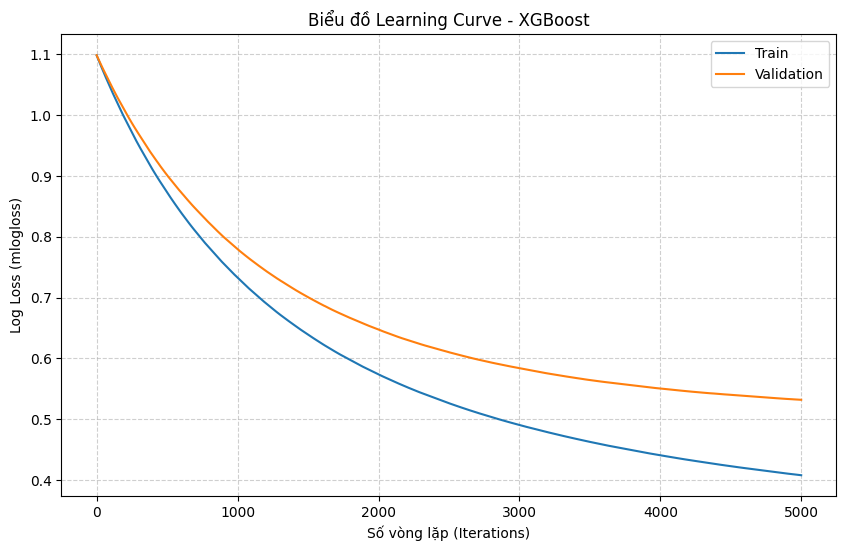

In [40]:
# --- BƯỚC 6: VẼ LEARNING CURVE ---
results = model.evals_result()
epochs = len(results['validation_0']['mlogloss'])
x_axis = range(0, epochs)

plt.figure(figsize=(10, 6))
plt.plot(x_axis, results['validation_0']['mlogloss'], label='Train')
plt.plot(x_axis, results['validation_1']['mlogloss'], label='Validation')
plt.legend()
plt.ylabel('Log Loss (mlogloss)')
plt.xlabel('Số vòng lặp (Iterations)')
plt.title('Biểu đồ Learning Curve - XGBoost')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

In [48]:
import optuna
from xgboost import XGBClassifier

def objective(trial):
    param = {
        'n_estimators': 1000,
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.05),
        'max_depth': trial.suggest_int('max_depth', 3, 9),
        'reg_lambda': trial.suggest_float('reg_lambda', 1.0, 20.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 10.0),
        'gamma': trial.suggest_float('gamma', 0.1, 2.0),
        'subsample': trial.suggest_float('subsample', 0.6, 0.9),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 0.9),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'objective': 'multi:softmax',
        'num_class': 3,
        'eval_metric': 'mlogloss',
        'early_stopping_rounds': 50,
        'random_state': 42
    }
    
    model = XGBClassifier(**param)
    model.fit(X_train_scaled, y_train, eval_set=[(X_val_scaled, y_val)], verbose=False)
    
    preds = model.predict(X_val_scaled)
    return accuracy_score(y_val, preds)

# Chạy tìm kiếm (Thử 50 lần)
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

print(f"Tham số tốt nhất: {study.best_params}")
print(f"Accuracy cao nhất đạt được: {study.best_value:.4f}")

[I 2026-01-19 01:22:11,541] A new study created in memory with name: no-name-e1738319-3798-4b1b-8ed9-fec4f7e3efd6
[I 2026-01-19 01:22:14,633] Trial 0 finished with value: 0.8262108262108262 and parameters: {'learning_rate': 0.021490412060259412, 'max_depth': 3, 'reg_lambda': 15.537418990689723, 'reg_alpha': 9.247719173515298, 'gamma': 0.13835627493897723, 'subsample': 0.8118697922710496, 'colsample_bytree': 0.7825506452847959, 'min_child_weight': 6}. Best is trial 0 with value: 0.8262108262108262.
[I 2026-01-19 01:22:17,086] Trial 1 finished with value: 0.8290598290598291 and parameters: {'learning_rate': 0.022923821079490873, 'max_depth': 3, 'reg_lambda': 14.439026184682954, 'reg_alpha': 4.3312579464756285, 'gamma': 1.1668971964728774, 'subsample': 0.6565305549883853, 'colsample_bytree': 0.6720309778337137, 'min_child_weight': 4}. Best is trial 1 with value: 0.8290598290598291.
[I 2026-01-19 01:22:19,540] Trial 2 finished with value: 0.828584995251662 and parameters: {'learning_rate':

Tham số tốt nhất: {'learning_rate': 0.04331850170664781, 'max_depth': 7, 'reg_lambda': 11.520606532242425, 'reg_alpha': 1.7403534486247323, 'gamma': 1.0061709654984443, 'subsample': 0.7022486945937182, 'colsample_bytree': 0.7853318414518897, 'min_child_weight': 2}
Accuracy cao nhất đạt được: 0.8348
